In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import math
from textstat import flesch_reading_ease
import random

In [2]:
def prepareData(paths: list):
    files = []
    n_entries = 0
    for path in paths:
        with open(path, 'r') as f:
            file = json.load(f)
            files.append(file)
            n_entries += len(file)
    df = pd.DataFrame(columns=['text','results'], index = [x for x in range(n_entries)])
    num = 0
    for file in files:
        for row in file:
            df.loc[num] = pd.Series({"text": row['data']['text'], "results": [x['value'] for x in row['annotations'][0]['result']]})
            num += 1
    return df

In [3]:
data = prepareData(['../NER_TRAIN_PREAMBLE.json', '../NER_TRAIN_JUDGEMENT.json'])

In [4]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

In [5]:
def top_ngrams_for_label(n_gram_size=2):
    labels = {}
    for i, row in data.iterrows():
        for d in row['results']:
            label = d['labels'][0]
            if label not in labels.keys():
                labels[label] = [row['text']]
            else:
                labels[label].append(row['text'])
    fig, axes = plt.subplots(2, 7, figsize=(30, 10))
    for i, label in enumerate(labels.keys()):
        top_ngrams_for_label = get_top_ngram(labels[label], n=n_gram_size)
        x,y=map(list,zip(*top_ngrams_for_label))
        sns.barplot(x=y,y=x, ax=axes[math.floor(i/7), i%7]).set_title(f"Top 10 {n_gram_size}-grams for label {label}")
    plt.tight_layout()
    plt.show()

In [6]:
def labels_hist():
    labels = {}
    for i, row in data.iterrows():
        for d in row['results']:
            label = d['labels'][0]
            if label not in labels.keys():
                labels[label] = [row['text']]
            else:
                labels[label].append(row['text'])
    x, y  = map(list, zip(*[(label, len(labels[label])) for label in labels.keys()]))
    fig, axes = plt.subplots(figsize=(15, 5))
    sns.barplot(x=x, y=y, ax=axes).set_title("Number of NER for each kind of them")
    plt.tight_layout()
    plt.show()

In [7]:
data.head()

,text,results
0,In The High Court Of Kerala At Ernakulam\n\nCr...,"[{'start': 7, 'end': 40, 'text': 'High Court O..."
1,In The Court Of Shri Lokesh Kumar Sharma\n ...,"[{'start': 21, 'end': 40, 'text': 'Lokesh Kuma..."
2,Before The Madurai Bench Of Madras High Court\...,"[{'start': 11, 'end': 45, 'text': 'Madurai Ben..."
3,Before The Madurai Bench Of Madras High Court\...,"[{'start': 11, 'end': 45, 'text': 'Madurai Ben..."
4,1 ...,"[{'start': 85, 'end': 119, 'text': 'High Court..."


Text(0.5, 1.0, 'Average number of words appearing in each text')

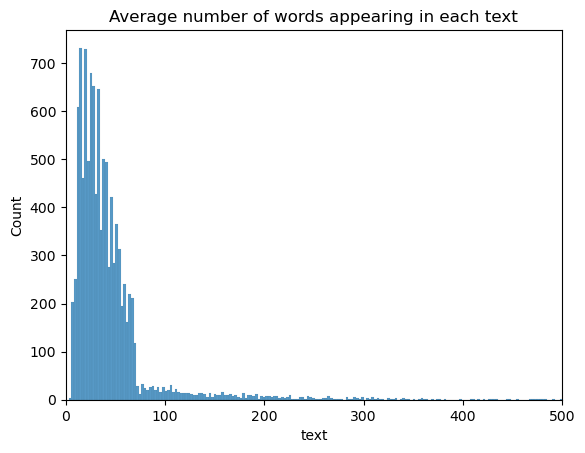

In [8]:
sent_len = data['text'].str.split().map(lambda x: len(x))
sns.histplot(sent_len)
plt.gca().set(xlim=(0, 500)) # set limit because there are some huge outliers
plt.title("Average number of words appearing in each text")

## We can see some weird outliers:

In [9]:
outlier = data.iloc[sent_len[sent_len == sent_len.max()].index[0]]['text'] # outlier with over 2700 words / tokens for querry
print(len(outlier.split()))
print(outlier)

2795
Reportable



                        In The Supreme Court Of India

                        Civil Appellate Jurisdiction

                 Civil Appeal No.     1699          Of 2012
                 (Arising out of Slp (C) No. 26558 Of 2010)

M/s Topman Exports                                       … Appellant

                                   Versus

Commissioner of Income Tax, Mumbai           … Respondent


                                    With

                      Civil Appeal No.   1700   Of 2012
                 (Arising out of Slp (C) No. 27418 of 2010),

                   Civil Appeal No.   1701         Of 2012
                 (Arising out of Slp (C) No.27552 of 2010),

                     Civil Appeal No.   1704     Of 2012
                 (Arising out of Slp (C) No.27583 of 2010),

                   Civil Appeal No.   1705         Of 2012
                 (Arising out of Slp (C) No. 27608 of 2010),

                     Civil Appeal No.   1706     Of 2012
  

Text(0.5, 1.0, 'Everage word length in each sentence')

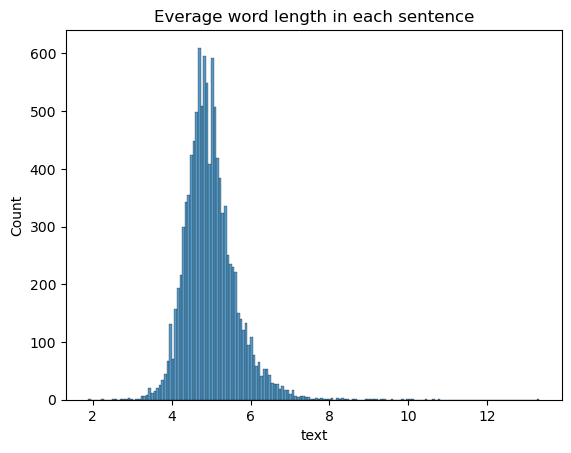

In [10]:
average_word_len = data['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
sns.histplot(average_word_len)
plt.title("Everage word length in each sentence")

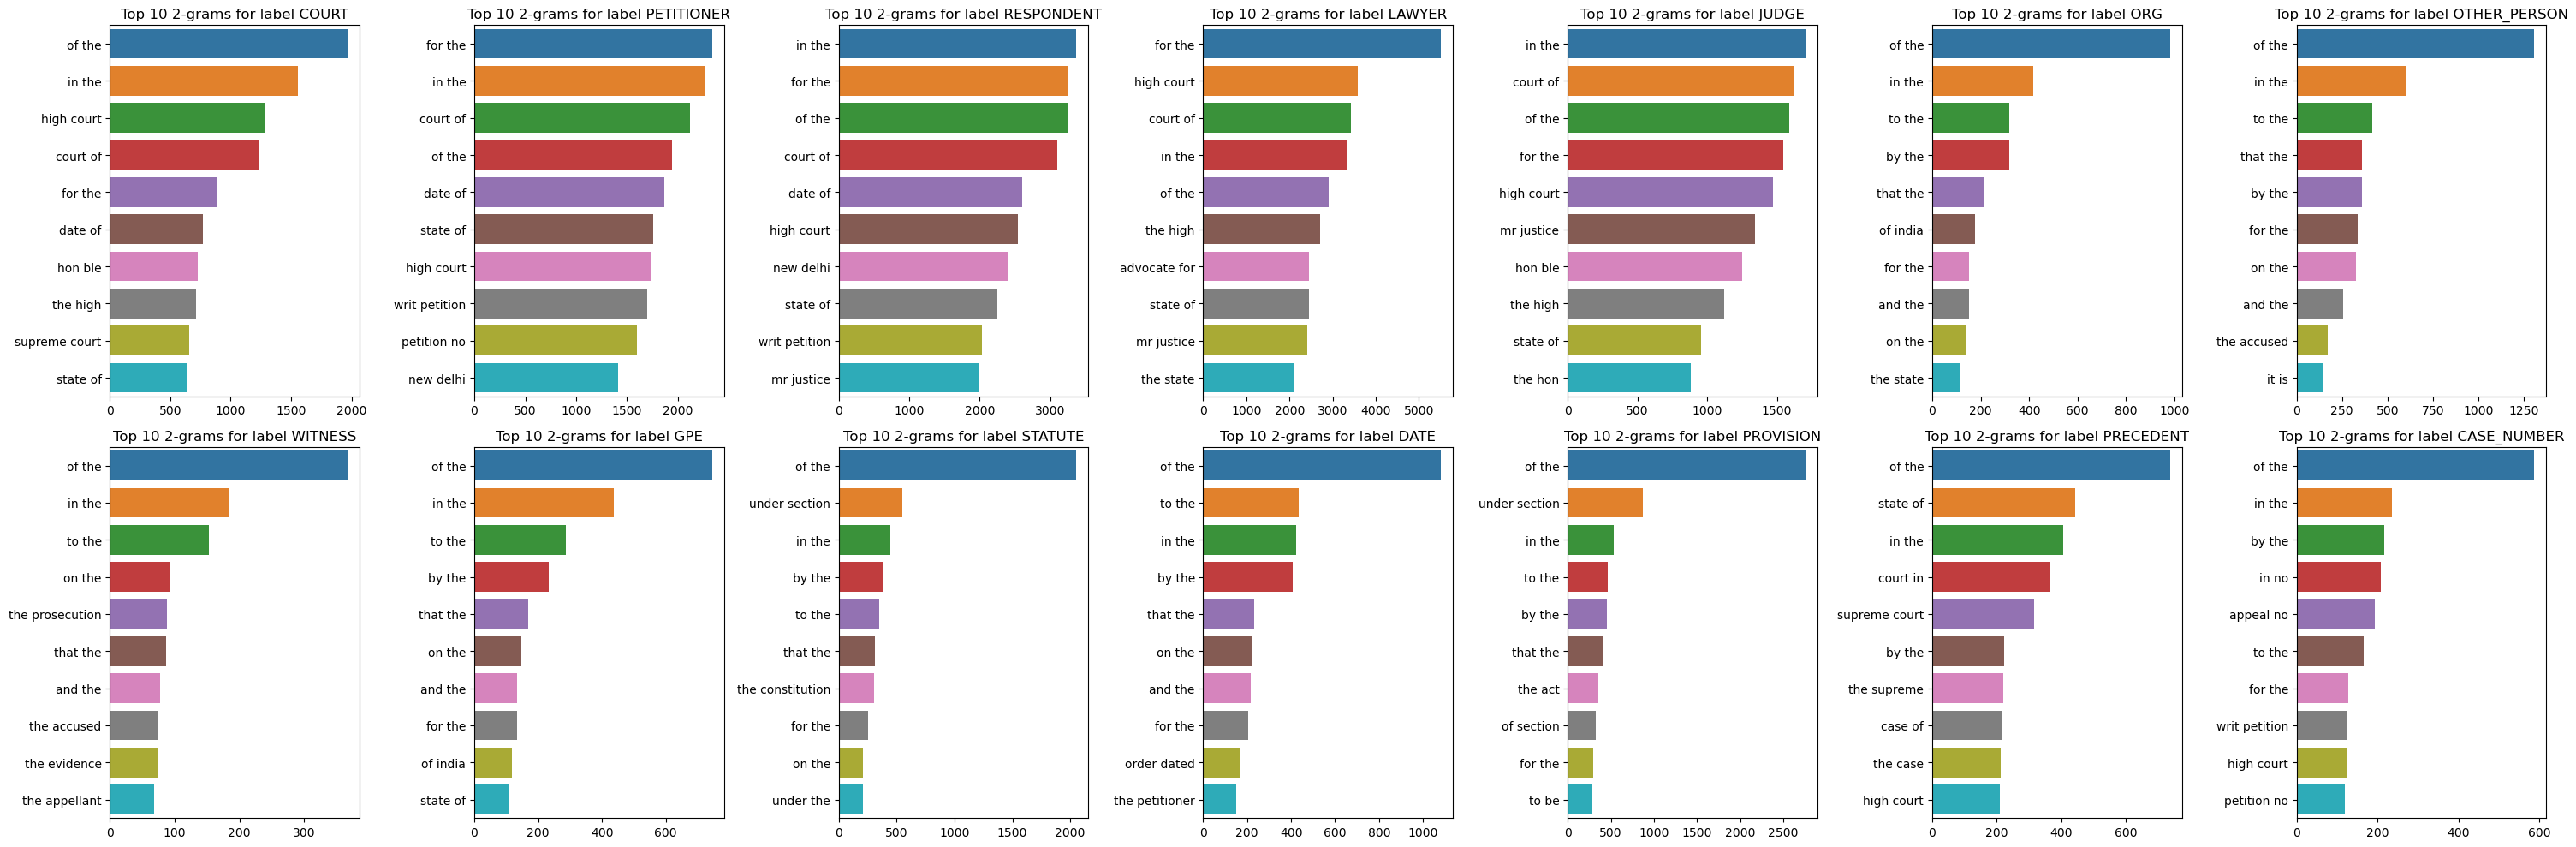

In [11]:
top_ngrams_for_label(n_gram_size=2)


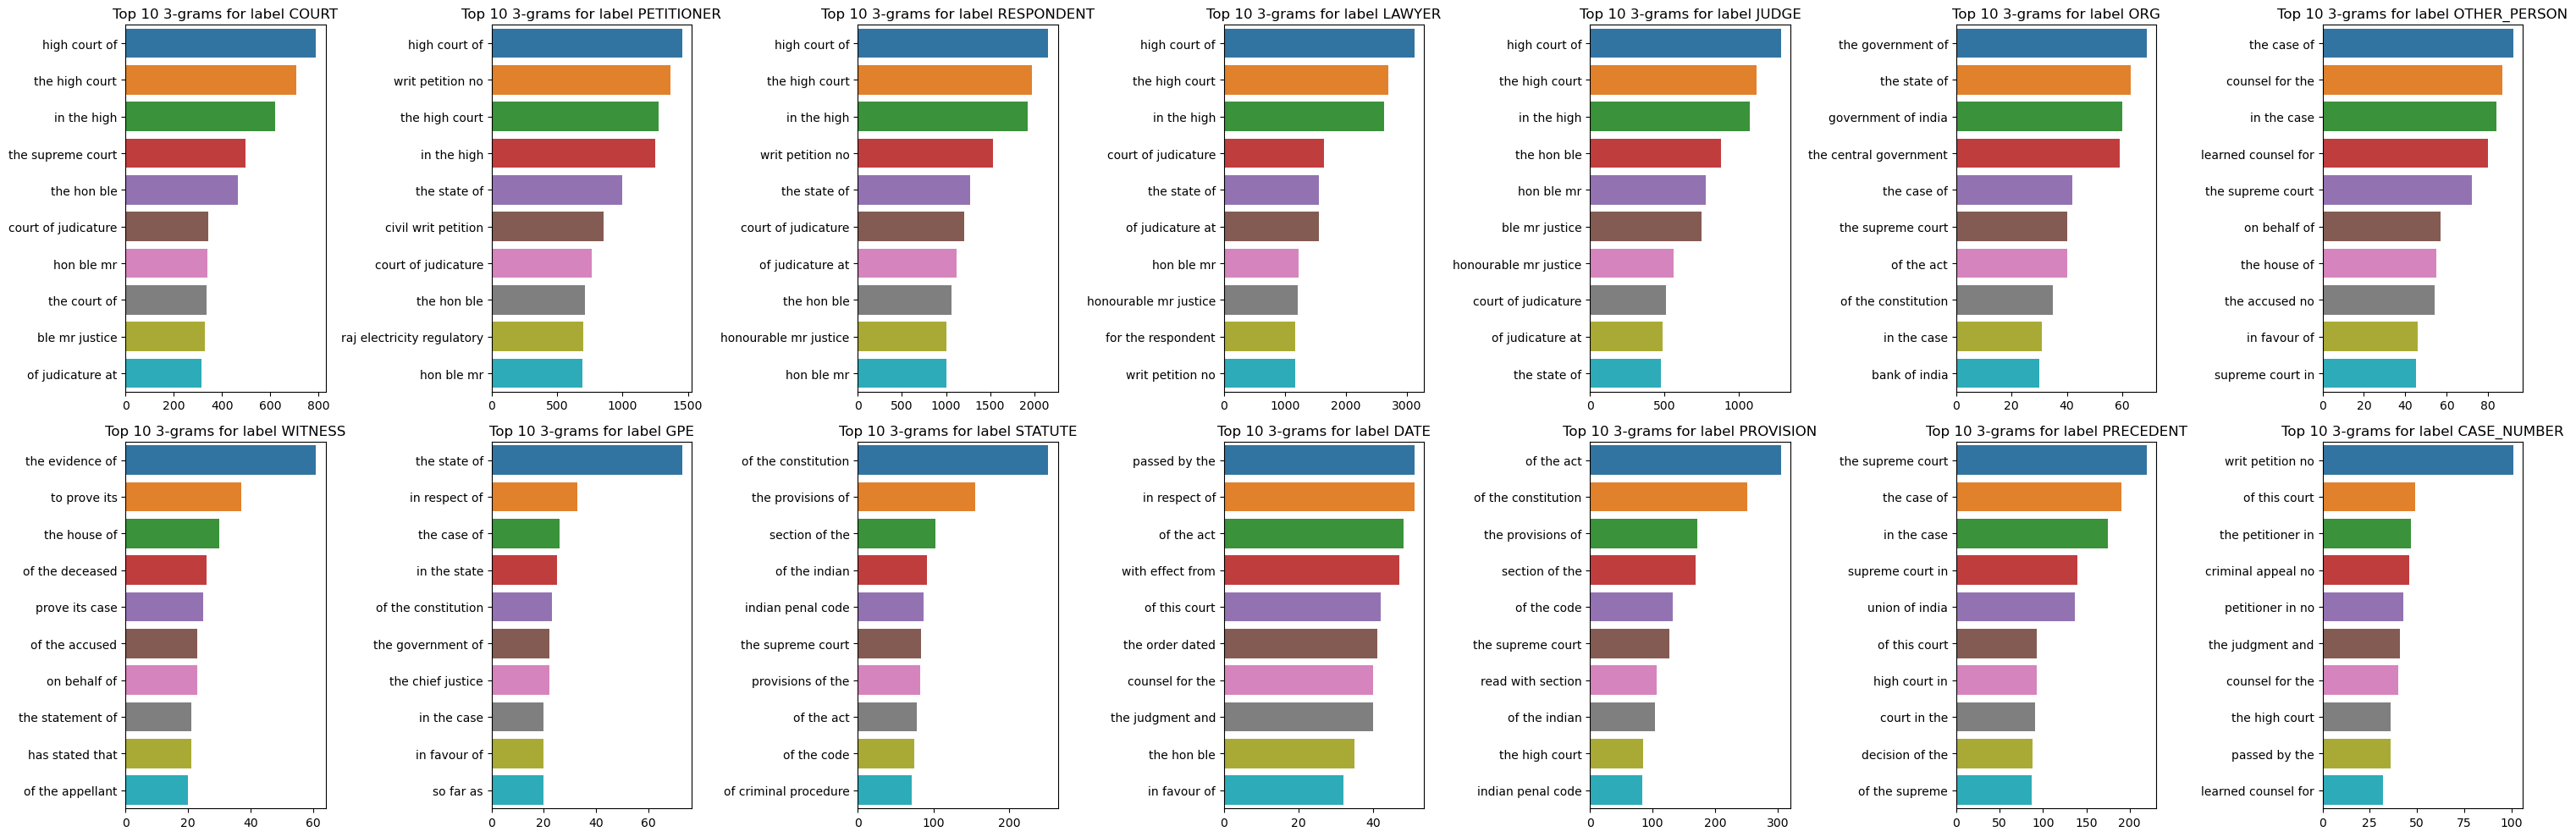

In [12]:
top_ngrams_for_label(n_gram_size=3)

Text(0.5, 1.0, 'Flesch Reading Ease Scores')

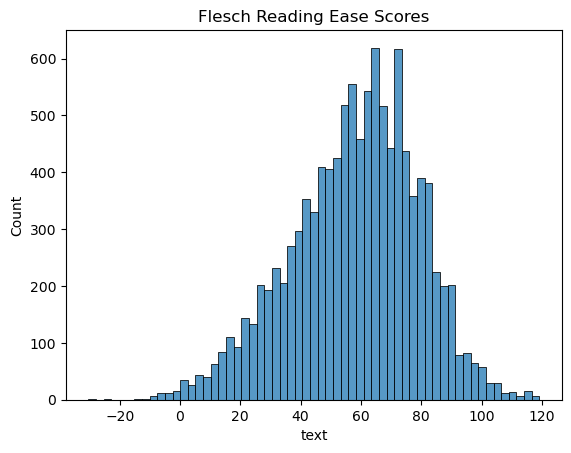

In [13]:
flesch_scores = data['text'].apply(lambda x: flesch_reading_ease(x))
sns.histplot(flesch_scores)
plt.title('Flesch Reading Ease Scores')

## Surprisingly majority of the querries is easy to read

FRE = 206.835 − 1.015 * (total words/total sentences)rn− 84.6 * (total syllables/ total words)

Higher scores indicate material that is easier to read,

lower numbers mark harder-to-read passages:

rn– 0-30 College 

rn– 50-60 High school

rn– 60+ Fourth grade

### Let's project the hardest ones:

In [14]:
random.seed(10)
x = [i for i in range(len(flesch_scores)) if flesch_scores[i]<10]
hard_to_read = data.iloc[x]
for x in range(4):
    print("Sentence number", x)
    print(hard_to_read.iloc[random.randint(0, len(hard_to_read))]['text'], end='\n\n')

Sentence number 0
In India, as has been shown there is a statutory right on the part of the police to investigate the circumstances of an alleged cognizable crime without requiring any authority from the judicial authorities, and it would, at their Lordships think, be an unfortunate result if it should be held possible to interfere with those statutory rights by an exercise of the inherent jurisdiction of the Court."

Sentence number 1
The above observations of the Tribunal made on the basis of the observations of the Supreme Court in Sahney Steel also how that the Tribunal was alive to the distinction between the character of the subsidy given with the object of promoting industrial growth in a particular area and the subsidy given conditional upon the commencement of production and after actual commencement of production.

Sentence number 2
Specific reference has been made to Krishena Kumar's case, supra, Indian Ex-Services League v Union of India, All India Reserve Bank Retired Offi

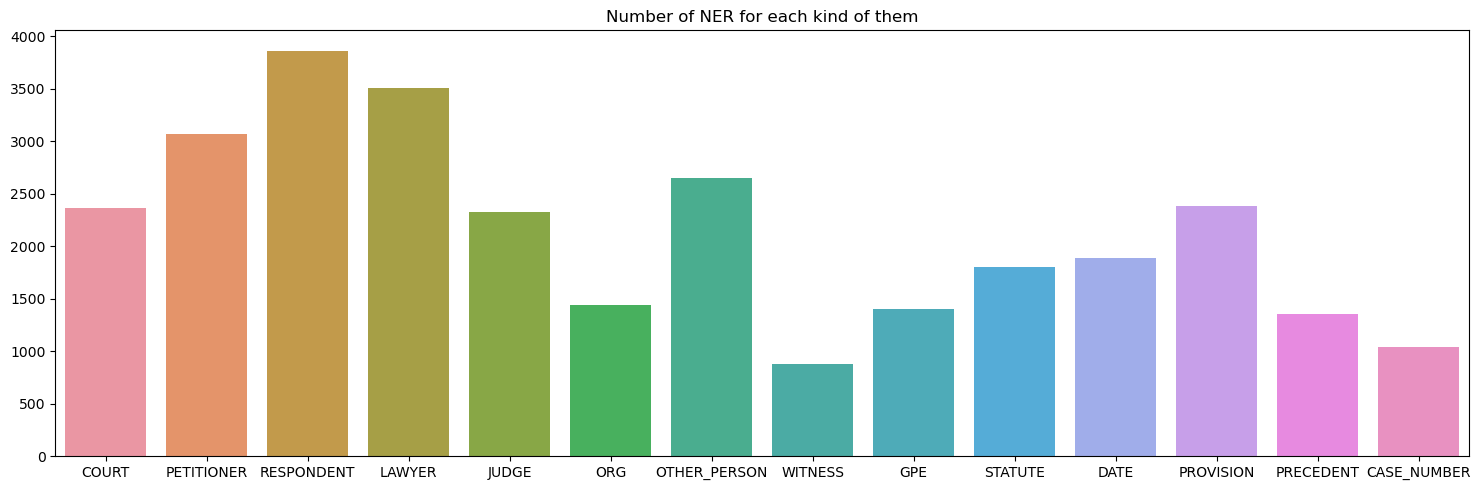

In [15]:
labels_hist()

### Detecting a witness might be tricky